# 01. 数据读取与预处理

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%pip install seaborn
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

     ------------------------------------ 294.9/294.9 kB 126.5 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [86]:
# tripdata = pd.read_csv('green_tripdata_2015-04.csv')
tripdata = pd.read_parquet('yellow_tripdata_2024-01.parquet')


In [103]:
df = tripdata.copy()
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


In [105]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee'],
      dtype='object')

In [106]:
df.isnull().sum()


VendorID                      0
tpep_pickup_datetime          0
tpep_dropoff_datetime         0
passenger_count          140162
trip_distance                 0
RatecodeID               140162
store_and_fwd_flag       140162
PULocationID                  0
DOLocationID                  0
payment_type                  0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
improvement_surcharge         0
total_amount                  0
congestion_surcharge     140162
Airport_fee              140162
dtype: int64

# 时间格式处理

In [107]:
df["pickup_datetime"] = pd.to_datetime(df["tpep_pickup_datetime"])
df["dropoff_datetime"] = pd.to_datetime(df["tpep_dropoff_datetime"])

# 数据填充和删除

In [108]:
df["tpep_pickup_datetime"].min(), df["tpep_pickup_datetime"].max()

(Timestamp('2002-12-31 22:59:39'), Timestamp('2024-02-01 00:01:15'))

In [109]:
print(f"Original data rows: {len(df)}")

# Filter out data before January 1, 2024
start_date = pd.Timestamp('2024-01-01')
df= df[df['tpep_pickup_datetime'] >= start_date].copy()

print(f"Cleaned data rows: {len(df)}")
print(f"Removed abnormal rows: {len(df) - len(df)}")

# Verify time range
df["tpep_pickup_datetime"].min(), df["tpep_pickup_datetime"].max()

Original data rows: 2964624
Cleaned data rows: 2964609
Removed abnormal rows: 0


(Timestamp('2024-01-01 00:00:00'), Timestamp('2024-02-01 00:01:15'))

In [ ]:
# Fill NaN with default values
df["passenger_count"] = df["passenger_count"].fillna(1)   # neutral value
df["congestion_surcharge"] = df["congestion_surcharge"].fillna(0)
df["Airport_fee"] = df["Airport_fee"].fillna(0)

# Drop columns that are useless for forecasting
df = df.drop(columns=["RatecodeID", "store_and_fwd_flag"])

# 异常值检测和清理

In [112]:
df = df[(df["trip_distance"] > 0) & (df["trip_distance"] <= 50)]

In [113]:
df["duration_min"] = (df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]).dt.total_seconds() / 60
df = df[(df["duration_min"] > 1) & (df["duration_min"] <= 180)]

In [116]:
df["speed_mph"] = df["trip_distance"] / (df["duration_min"] / 60)

df = df[(df["speed_mph"] > 1) & (df["speed_mph"] <= 80)]

In [117]:
df = df[df["dropoff_datetime"] >= df["pickup_datetime"]]


In [118]:
# 检查负数
fare_cols = ["fare_amount","extra","mta_tax","tip_amount",
             "tolls_amount","improvement_surcharge","total_amount"]

for col in fare_cols:
    df = df[df[col] >= 0]


In [119]:
df = df[df["total_amount"] >= df["fare_amount"]]

# 查看清洗后数据

In [162]:
df = df[[
    "pickup_datetime", "dropoff_datetime",
    "PULocationID", "DOLocationID",
    "passenger_count", "trip_distance",
    "duration_min", "speed_mph",
    "payment_type",
    "fare_amount","extra","mta_tax","tip_amount",
    "tolls_amount","improvement_surcharge",
    "congestion_surcharge","Airport_fee",
    "total_amount"
]].reset_index(drop=True)


In [163]:
print("Original size:", tripdata.shape)
print("Cleaned size:", df.shape)
print("Removed rows:", tripdata.shape[0] - df.shape[0])


Original size: (2964624, 19)
Cleaned size: (2857016, 18)
Removed rows: 107608


# Time feature EDA

In [166]:
df["hour"] = df["pickup_datetime"].dt.hour
df["weekday"] = df["pickup_datetime"].dt.dayofweek   # 0=Mon
df["day"] = df["pickup_datetime"].dt.day
df["month"] = df["pickup_datetime"].dt.month


Hourly Demand

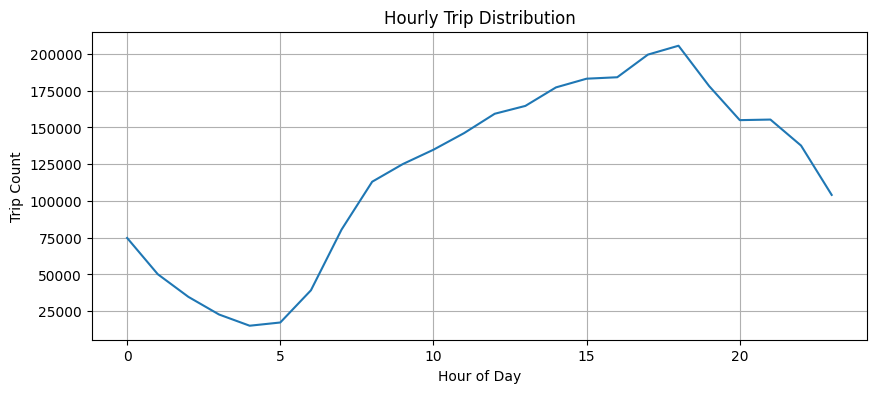

In [167]:
hourly_counts = df.groupby("hour").size()

plt.figure(figsize=(10,4))
sns.lineplot(x=hourly_counts.index, y=hourly_counts.values)
plt.title("Hourly Trip Distribution")
plt.xlabel("Hour of Day")
plt.ylabel("Trip Count")
plt.grid(True)
plt.show()


Weekly Demand

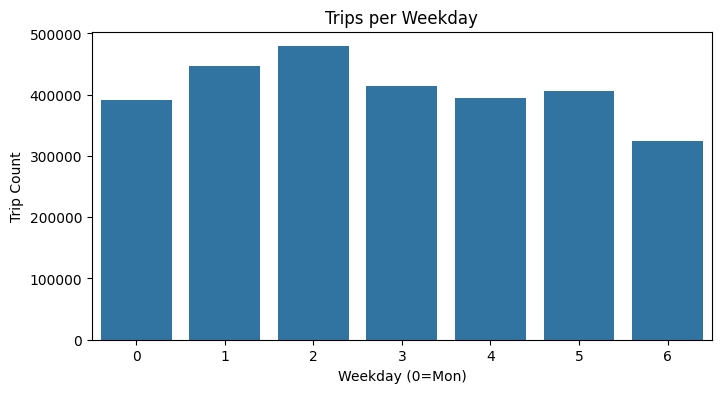

In [168]:
weekday_counts = df.groupby("weekday").size()

plt.figure(figsize=(8,4))
sns.barplot(x=weekday_counts.index, y=weekday_counts.values)
plt.title("Trips per Weekday")
plt.xlabel("Weekday (0=Mon)")
plt.ylabel("Trip Count")
plt.show()

# 空间特征EDA

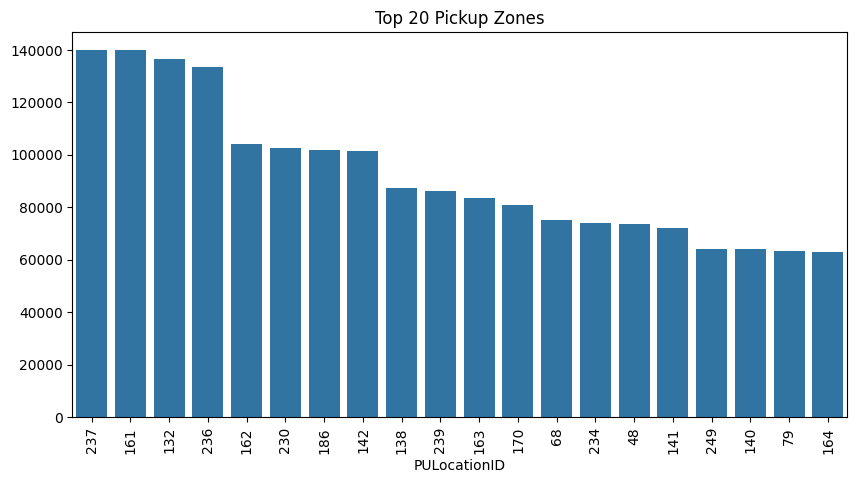

In [169]:
pu_counts = df["PULocationID"].value_counts().head(20)

plt.figure(figsize=(10,5))
sns.barplot(x=pu_counts.index.astype(str), y=pu_counts.values)
plt.xticks(rotation=90)
plt.title("Top 20 Pickup Zones")
plt.show()

<Axes: xlabel='DOLocationID'>

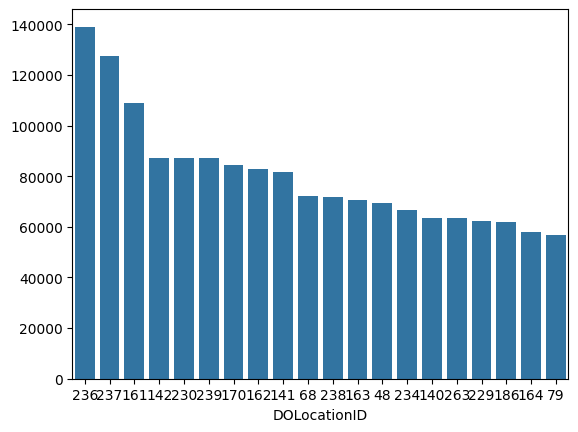

In [170]:
do_counts = df["DOLocationID"].value_counts().head(20)
sns.barplot(x=do_counts.index.astype(str), y=do_counts.values)


# OD Pair EDA（Origin → Destination）

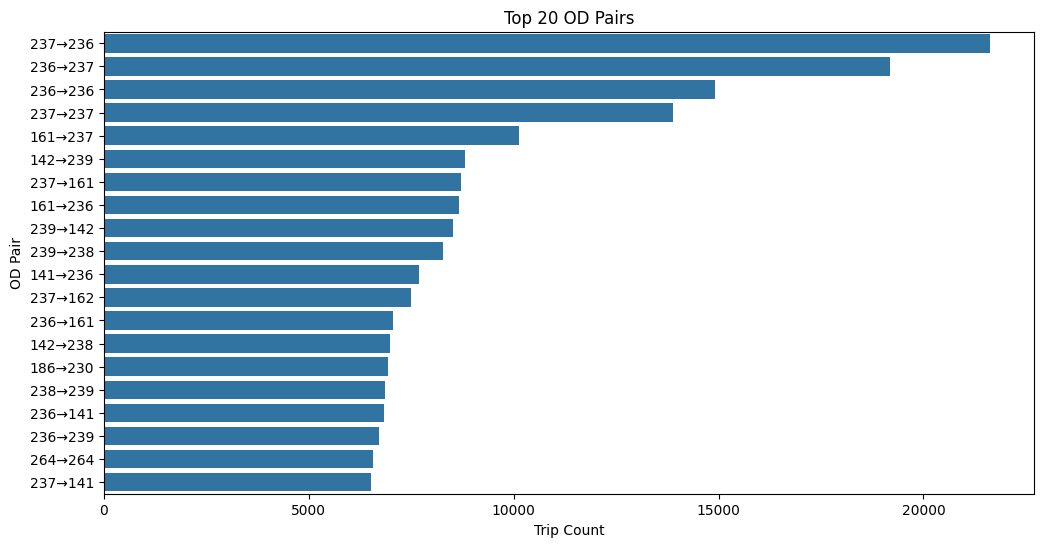

In [171]:
df["OD_pair"] = df["PULocationID"].astype(str) + "→" + df["DOLocationID"].astype(str)
od_counts = df["OD_pair"].value_counts().head(20)

plt.figure(figsize=(12,6))
sns.barplot(x=od_counts.values, y=od_counts.index)
plt.title("Top 20 OD Pairs")
plt.xlabel("Trip Count")
plt.ylabel("OD Pair")
plt.show()


# Trip Quality EDA

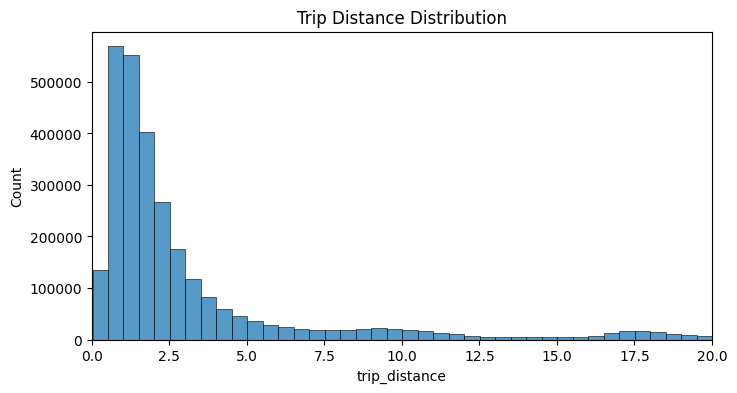

In [172]:
plt.figure(figsize=(8,4))
sns.histplot(df["trip_distance"], bins=100)
plt.xlim(0,20)
plt.title("Trip Distance Distribution")
plt.show()


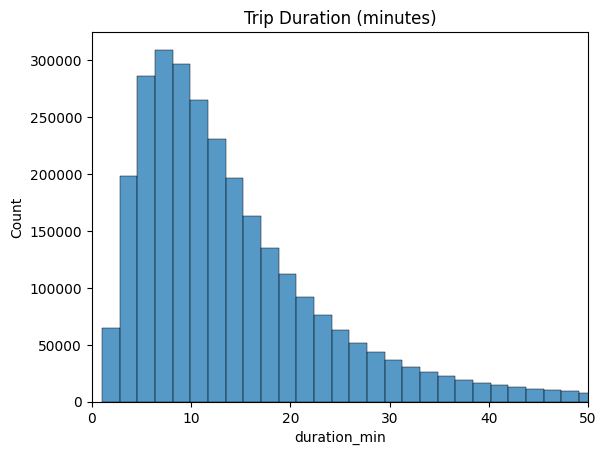

In [173]:
df["duration_min"] = (df["dropoff_datetime"] - df["pickup_datetime"]).dt.total_seconds() / 60

sns.histplot(df["duration_min"], bins=100)
plt.xlim(0,50)
plt.title("Trip Duration (minutes)")
plt.show()


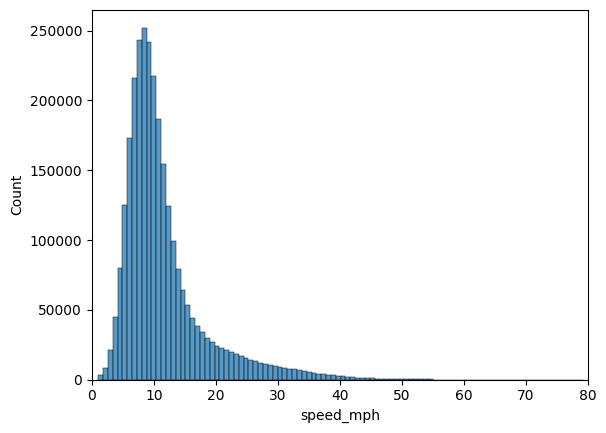

In [174]:
df["speed_mph"] = df["trip_distance"] / (df["duration_min"] / 60)
sns.histplot(df["speed_mph"], bins=100)
plt.xlim(0,80)
plt.show()


# 费用 EDA

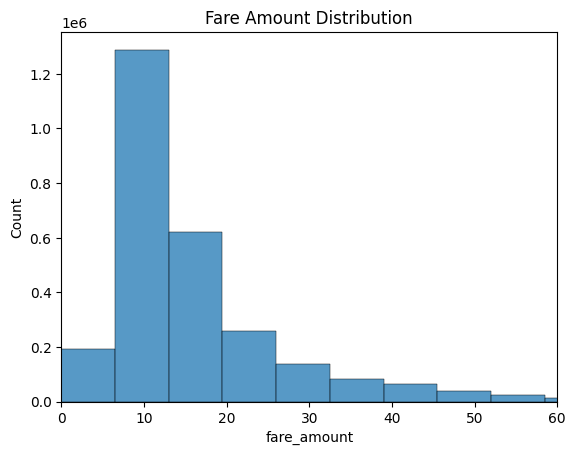

In [175]:
sns.histplot(df["fare_amount"], bins=100)
plt.xlim(0,60)
plt.title("Fare Amount Distribution")
plt.show()


# 时空需求（核心任务）EDA
Insight： 不同区域 demand 模式不同 → 是采用 GCN-LSTM 的理论基础。

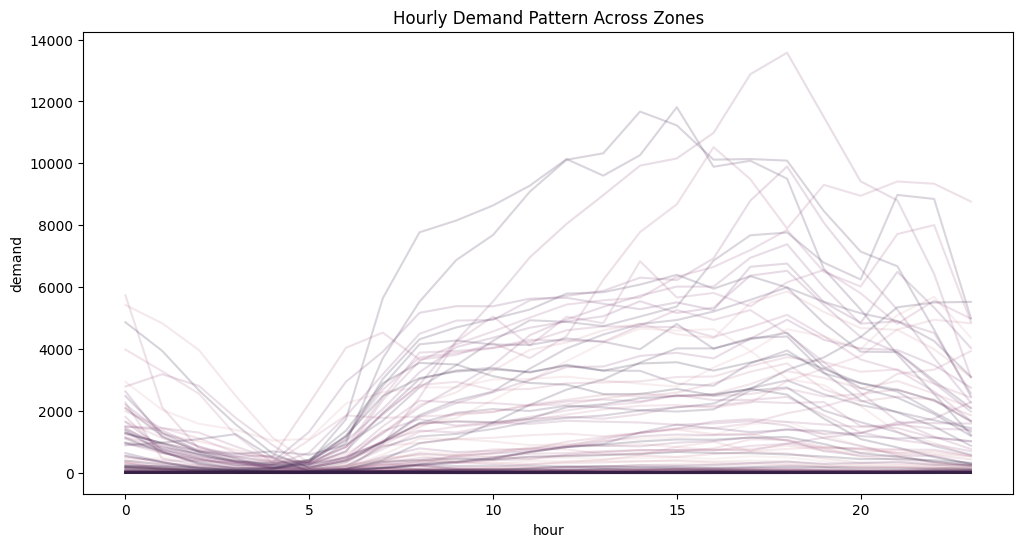

In [176]:
zone_hour = df.groupby(["PULocationID", "hour"]).size().reset_index(name="demand")

plt.figure(figsize=(12,6))
sns.lineplot(data=zone_hour, x="hour", y="demand", hue="PULocationID", legend=False, alpha=0.2)
plt.title("Hourly Demand Pattern Across Zones")
plt.show()


Step 1 — 构建 Demand Time Series（按区域 + 时间）

你的模型（MA / XGBoost / GCN-LSTM）全部都是基于：demand(PU_zone, time_bin)

In [177]:
df["time_bin"] = df["pickup_datetime"].dt.floor("1H")

In [178]:
demand_ts = (
    df.groupby(["PULocationID", "time_bin"])
      .size()
      .reset_index(name="demand")
)

In [179]:
df["pickup_datetime"].min(), df["pickup_datetime"].max()

(Timestamp('2024-01-01 00:00:00'), Timestamp('2024-02-01 00:01:15'))

In [181]:
# 生成完整的时间序列（填补没有 trip 的 hour）
# 全量时间（2024整年）
full_time_range = pd.date_range(
    start=demand_ts["time_bin"].min(),
    end=demand_ts["time_bin"].max(),
    freq="1H"
)

zones = df["PULocationID"].unique()

# 建立完整网格
grid = pd.MultiIndex.from_product(
    [zones, full_time_range],
    names=["PULocationID", "time_bin"]
)

demand_full = (
    demand_ts.set_index(["PULocationID", "time_bin"])
             .reindex(grid, fill_value=0)
             .reset_index()
)


Step 2 — 加入 Temporal Features

In [182]:
demand_full["hour"] = demand_full["time_bin"].dt.hour
demand_full["weekday"] = demand_full["time_bin"].dt.dayofweek
demand_full["month"] = demand_full["time_bin"].dt.month

Step3——加入holiday

In [183]:
%pip install holidays
import holidays
us_holidays = holidays.UnitedStates()

demand_full["is_holiday"] = demand_full["time_bin"].dt.date.astype(str).isin(
    us_holidays
).astype(int)


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# 聚合天气数据

In [ ]:
# %pip install meteostat


[notice] A new release of pip available: 22.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [184]:
# 获取 NYC Central Park（站点ID：72506） 的逐小时天气数据
from meteostat import Hourly, Stations
import pandas as pd
from datetime import datetime

# 定义 NYC 时间范围
start = df["pickup_datetime"].min()
end = df["pickup_datetime"].max()

# 搜索纽约最近的气象站（中央公园）
stations = Stations()
stations = stations.nearby(40.7812, -73.9665)  # Central Park坐标
station = stations.fetch(1).iloc[0]
station


name             New York City / Yorkville
country                                 US
region                                  NY
wmo                                   <NA>
icao                                  KNYC
latitude                           40.7789
longitude                         -73.9692
elevation                              3.0
timezone                  America/New_York
hourly_start           1943-12-01 00:00:00
hourly_end             2025-11-17 00:00:00
daily_start            1943-12-02 00:00:00
daily_end              2022-04-24 00:00:00
monthly_start          1944-01-01 00:00:00
monthly_end            2021-01-01 00:00:00
distance                        342.183911
Name: KNYC0, dtype: object

In [185]:
df["pickup_datetime"].min(), df["pickup_datetime"].max()

(Timestamp('2024-01-01 00:00:00'), Timestamp('2024-02-01 00:01:15'))

In [186]:
# Download hourly weather data - Fixed version
from meteostat import Point, Hourly
import pandas as pd

# Step 1: Define time range (based on your taxi data)
start = df["pickup_datetime"].min()
end = df["pickup_datetime"].max()

print(f"Fetching weather data for time range: {start} to {end}")

# Step 2: Use Point API to get hourly weather for NYC coordinates
nyc = Point(40.7128, -74.0060, 10)  # NYC coordinates (lat, lon, altitude)
weather = Hourly(nyc, start, end, timezone='America/New_York')

# Step 3: Fetch the data
weather_data = weather.fetch()

print(f"Weather data shape: {weather_data.shape}")

# Step 4: Reset index and rename time column
weather_data = weather_data.reset_index().rename(columns={"time": "time_bin"})

print("Weather data sample:")
print(weather_data.head())

print(f"Temperature data coverage: {weather_data['temp'].notna().sum()}/{len(weather_data)} rows")

# Optional: Check data quality
if not weather_data.empty:
    print("\nWeather data statistics:")
    print(weather_data[['temp', 'prcp', 'rhum', 'wspd']].describe())

Fetching weather data for time range: 2024-01-01 00:00:00 to 2024-02-01 00:01:15
Weather data shape: (745, 11)
Weather data sample:
                   time_bin  temp  dwpt  rhum  prcp  snow   wdir  wspd  wpgt  \
0 2024-01-01 00:00:00-05:00   5.6  -0.7  64.0   0.0  <NA>  250.0  14.8  <NA>   
1 2024-01-01 01:00:00-05:00   5.6  -0.7  64.0   0.0  <NA>  260.0  14.8  <NA>   
2 2024-01-01 02:00:00-05:00   5.6  -0.7  64.0   0.0  <NA>  270.0  11.2  <NA>   
3 2024-01-01 03:00:00-05:00   5.0  -0.6  67.0   0.0  <NA>  260.0  11.2  <NA>   
4 2024-01-01 04:00:00-05:00   5.0  -1.0  65.0   0.0  <NA>  250.0   7.6  <NA>   

     pres  tsun  coco  
0  1016.7  <NA>   3.0  
1  1016.4  <NA>   3.0  
2  1016.2  <NA>   3.0  
3  1016.2  <NA>   3.0  
4  1015.8  <NA>   3.0  
Temperature data coverage: 745/745 rows

Weather data statistics:
           temp      prcp       rhum       wspd
count     745.0     745.0      745.0      745.0
mean   3.011409  0.225638  68.791946  12.780134
std    4.236714  1.051343  16.222

In [187]:
# Merge weather data with demand data
weather_data = weather_data.reset_index().rename(columns={"time": "time_bin"})
weather_data['time_bin'] = weather_data['time_bin'].dt.tz_localize(None)

print("Weather data sample:")
print(weather_data[['time_bin', 'temp', 'prcp']].head())

# Merge datasets
demand_weather = demand_full.merge(weather_data, on="time_bin", how="left")

print(f"Merged Data: {demand_weather.shape}")

# Check missing data
print("\nMissing weather data:")
for col in ['temp', 'prcp', 'rhum', 'wspd']:
    missing_pct = demand_weather[col].isna().mean() * 100
    print(f"{col}: {missing_pct:.1f}%")

# Show result
print("\nMerged data sample:")
print(demand_weather[['PULocationID', 'time_bin', 'demand', 'temp', 'prcp']].head())

Weather data sample:
             time_bin  temp  prcp
0 2024-01-01 00:00:00   5.6   0.0
1 2024-01-01 01:00:00   5.6   0.0
2 2024-01-01 02:00:00   5.6   0.0
3 2024-01-01 03:00:00   5.0   0.0
4 2024-01-01 04:00:00   5.0   0.0
Merged Data: (190720, 19)

Missing weather data:
temp: 0.0%
prcp: 0.0%
rhum: 0.0%
wspd: 0.0%

Merged data sample:
   PULocationID            time_bin  demand  temp  prcp
0           186 2024-01-01 00:00:00     101   5.6   0.0
1           186 2024-01-01 01:00:00     101   5.6   0.0
2           186 2024-01-01 02:00:00      83   5.6   0.0
3           186 2024-01-01 03:00:00     148   5.0   0.0
4           186 2024-01-01 04:00:00      63   5.0   0.0


In [190]:
demand_weather

,PULocationID,time_bin,demand,hour,weekday,month,is_holiday,index,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
0,186,2024-01-01 00:00:00,101,0,0,1,0,0,5.6,-0.7,64.0,0.0,<NA>,250.0,14.8,<NA>,1016.7,<NA>,3.0
1,186,2024-01-01 01:00:00,101,1,0,1,0,1,5.6,-0.7,64.0,0.0,<NA>,260.0,14.8,<NA>,1016.4,<NA>,3.0
2,186,2024-01-01 02:00:00,83,2,0,1,0,2,5.6,-0.7,64.0,0.0,<NA>,270.0,11.2,<NA>,1016.2,<NA>,3.0
3,186,2024-01-01 03:00:00,148,3,0,1,0,3,5.0,-0.6,67.0,0.0,<NA>,260.0,11.2,<NA>,1016.2,<NA>,3.0
4,186,2024-01-01 04:00:00,63,4,0,1,0,4,5.0,-1.0,65.0,0.0,<NA>,250.0,7.6,<NA>,1015.8,<NA>,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190715,109,2024-01-31 20:00:00,0,20,2,1,0,740,3.3,-0.5,76.0,0.0,<NA>,250.0,5.4,<NA>,1019.3,<NA>,3.0
190716,109,2024-01-31 21:00:00,0,21,2,1,0,741,3.3,-0.5,76.0,0.0,<NA>,250.0,5.4,<NA>,1019.1,<NA>,3.0
190717,109,2024-01-31 22:00:00,0,22,2,1,0,742,2.8,-0.0,82.0,0.0,<NA>,260.0,5.4,<NA>,1019.1,<NA>,3.0
190718,109,2024-01-31 23:00:00,0,23,2,1,0,743,2.8,-0.0,82.0,0.0,<NA>,230.0,7.6,<NA>,1019.3,<NA>,3.0


In [ ]:
# 补齐天气缺失值

weather_cols = ["temp", "rhum", "prcp", "snow", "wspd", "pres"]

for col in weather_cols:
    demand_weather[col] = demand_weather[col].fillna(method="ffill")


In [151]:
import requests

def get_openmeteo_fallback(start, end):
    """Free historical weather API"""
    try:
        url = "https://archive-api.open-meteo.com/v1/archive"
        params = {
            "latitude": 40.7128, "longitude": -74.0060,
            "start_date": start.strftime('%Y-%m-%d'),
            "end_date": end.strftime('%Y-%m-%d'),
            "hourly": "temperature_2m,relative_humidity_2m,precipitation,wind_speed_10m",
            "timezone": "auto"
        }
        
        response = requests.get(url, params=params, timeout=30)
        if response.status_code == 200:
            data = response.json()
            df = pd.DataFrame({
                'time_bin': pd.to_datetime(data['hourly']['time']),
                'temp': data['hourly']['temperature_2m'],
                'rhum': data['hourly']['relative_humidity_2m'], 
                'prcp': data['hourly']['precipitation'],
                'wspd': data['hourly']['wind_speed_10m']
            })
            print(f"✅ Open-Meteo data retrieved: {len(df)} records")
            return df
    except Exception as e:
        print(f"Open-Meteo failed: {e}")
    return None

# Try the fallback
fallback_weather = get_openmeteo_fallback(start, end)

✅ Open-Meteo data retrieved: 768 records


In [152]:
from meteostat import Point, Hourly
import pandas as pd

def fetch_meteostat_point_weather(start, end):
    """
    使用 Point 类获取 NYC 坐标的天气数据
    """
    try:
        # 定义 NYC 坐标 (纬度, 经度, 海拔)
        nyc = Point(40.7128, -74.0060, 10)  # NYC 坐标，海拔10米
        
        # 获取小时数据
        weather = Hourly(nyc, start, end, timezone='America/New_York')
        weather_data = weather.fetch()
        
        print(f"使用 Point API 获取的数据形状: {weather_data.shape}")
        
        if not weather_data.empty:
            # 重置索引并重命名时间列
            weather_data = weather_data.reset_index()
            weather_data = weather_data.rename(columns={'time': 'time_bin'})
            
            print("✅ 成功通过 Point API 获取天气数据")
            print(f"数据列: {weather_data.columns.tolist()}")
            print(f"时间范围: {weather_data['time_bin'].min()} 到 {weather_data['time_bin'].max()}")
            print(f"温度数据覆盖率: {weather_data['temp'].notna().sum()}/{len(weather_data)}")
            
            return weather_data
        else:
            print("❌ Point API 返回空数据")
            return None
            
    except Exception as e:
        print(f"❌ Point API 错误: {e}")
        return None

# 测试 Point API
start = pd.Timestamp('2024-01-01')
end = pd.Timestamp('2024-02-01')

print("=== 测试 Meteostat Point API ===")
point_weather = fetch_meteostat_point_weather(start, end)

if point_weather is not None:
    print("Point API 数据样本:")
    print(point_weather[['time_bin', 'temp', 'prcp', 'rhum', 'wspd']].head())

=== 测试 Meteostat Point API ===
使用 Point API 获取的数据形状: (745, 11)
✅ 成功通过 Point API 获取天气数据
数据列: ['time_bin', 'temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres', 'tsun', 'coco']
时间范围: 2024-01-01 00:00:00-05:00 到 2024-02-01 00:00:00-05:00
温度数据覆盖率: 745/745
Point API 数据样本:
                   time_bin  temp  prcp  rhum  wspd
0 2024-01-01 00:00:00-05:00   5.6   0.0  64.0  14.8
1 2024-01-01 01:00:00-05:00   5.6   0.0  64.0  14.8
2 2024-01-01 02:00:00-05:00   5.6   0.0  64.0  11.2
3 2024-01-01 03:00:00-05:00   5.0   0.0  67.0  11.2
4 2024-01-01 04:00:00-05:00   5.0   0.0  65.0   7.6


# 展示Location 分布